# Metro Operations Optimization

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [3]:
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
shapes = pd.read_csv('shapes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

## Feature Enginerring

### Date into Date Dtype & Format

In [4]:
calendar['start_date'] = pd.to_datetime(calendar['start_date'], format='%Y%m%d')
calendar['end_date'] = pd.to_datetime(calendar['end_date'], format='%Y%m%d')

## Exploratory Analysis

### geographical routes

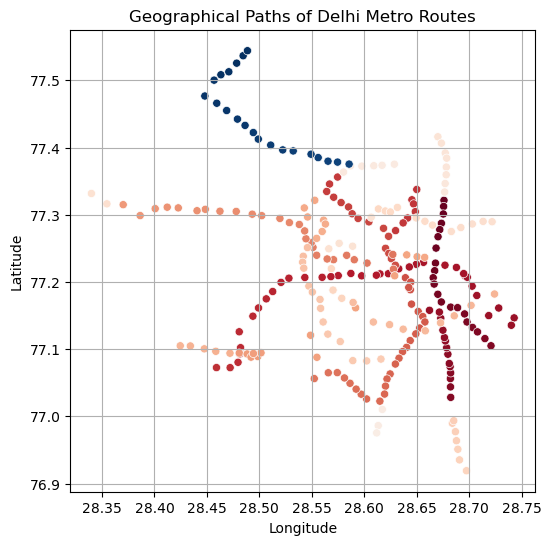

In [5]:
fig, ax = plt.subplots(figsize = (6,6))
sns.scatterplot(data = stops, x = 'stop_lat', y = 'stop_lon', s = 35,hue = 'stop_id', palette = "RdBu", legend = None, ax = ax)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

The map visualization shows the geographical path of delhi metro. Each line identifies in different color show the different routes. This visuals help in understand the how the metro routes in delhi and demonstrating the connectivity and spread of the network.

### Trips per Day of the Week

In [6]:
trips_merged = trips.merge(calendar, how = 'left', on = 'service_id')
trip_count = trips_merged[['monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday']]

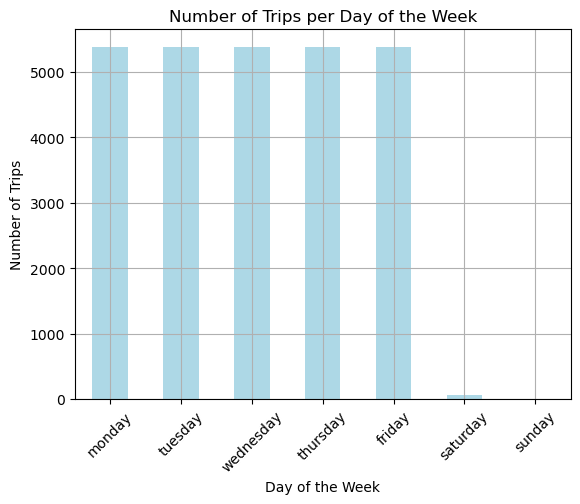

In [7]:
trip_count.sum(axis = 0).plot(kind = 'bar', color = 'lightblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

This visual shows that the Monday, tuesday, wednesday, thrusday, friday is consistent. indicating a stable weekday schedule designed to accommodate regular commuter traffic.  In contrast, the trips decrease slightly on Saturday and even more on Sunday, reflecting lower demand or a reduced service schedule on weekends.

This finding suggests that the Delhi Metro strategically scales its operations based on the expected daily ridership, which likely peaks during weekdays due to work and school commutes.

###  Route complexity

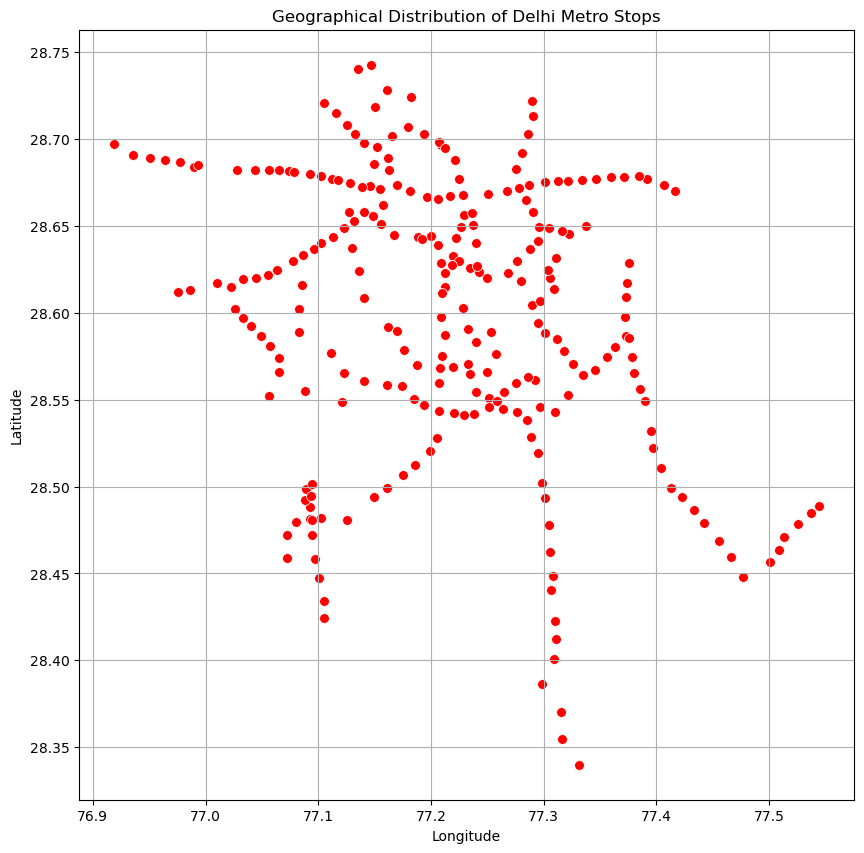

In [8]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='o')
plt.title('Geographical Distribution of Delhi Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

the Scatter PLot above show the geographical representation of delhi metro stops. Each red dot represent the delhi metro stop and their distribution across the map illustrates how the stops cover different areas of Delhi.

From the plot, we can see widespread distribution. This shows the delhi metro provide good spatial coverage allowing access to broad area and faciliting efficient travel across the area. 

The stops are fairly distributed but in someplace there is denser clusters, which indicates area with high transit needs or connect central hubs. 

In [9]:
stop_with_routes = stop_times.merge(trips, how = 'inner', on = 'trip_id')

In [10]:
routes_count = stop_with_routes.groupby('stop_id', as_index = False)['route_id'].nunique()
routes_count = routes_count.rename(columns = {'route_id':'Number_of_routes'})

In [11]:
stop_routes = stops.merge(routes_count, on = 'stop_id')

In [12]:
cl = sns.color_palette("Spectral", as_cmap=True)

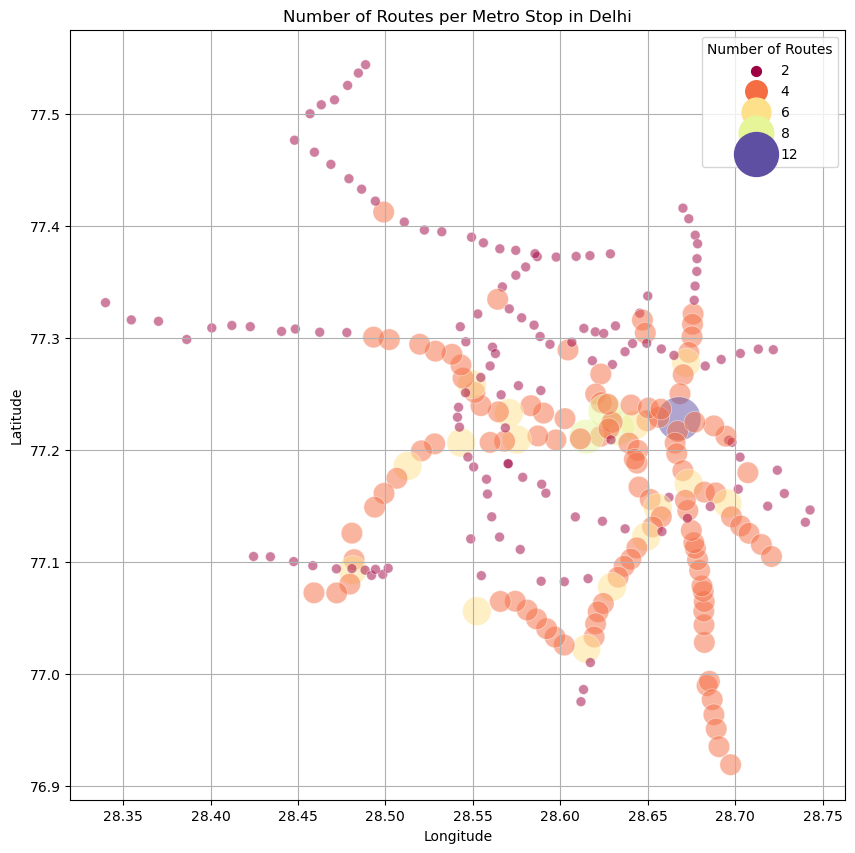

In [13]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = stop_routes, x = 'stop_lat', y = 'stop_lon',s=25 ,size='Number_of_routes', sizes=(50, 1000), hue = 'Number_of_routes', alpha =0.5,palette=cl)
plt.title('Number of Routes per Metro Stop in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()

This illustration show the distribution of routes accross delhi metro different stops.

- Hub and Transfer Points = Big circle shows there is hub or transfer points that demonstrate high traffic, faciliate easy transfer across the city.
- Distribution  - small circle leds to more periphal and less busy lines. The central area are of more populated zones.

### Service frequency

In [14]:
import datetime as dt

def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

In [15]:
stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)
stop_time_sorted = stop_times.sort_values(by = ['stop_id','arrival_time_dt'])
stop_time_sorted['next_arrival_time'] = stop_time_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

In [16]:
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    else:
        full_time1 = dt.datetime.combine(dt.date.today(), time1)
        full_time2 = dt.datetime.combine(dt.date.today(), time2)
        return (full_time2 - full_time1).seconds / 60

stop_time_sorted['interval_minutes'] = stop_time_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis = 1)

In [17]:
stop_times_intervals = stop_time_sorted.dropna(subset = 'interval_minutes')

In [18]:
def part_of_day(time):
    if time < dt.time(12,0):
        return 'Morning'
    elif time < dt.time(17,0):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)

C:\Users\AFZAL\AppData\Local\Temp\ipykernel_11536\475100240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)


In [19]:
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

In [20]:
counts = stop_times_intervals.groupby('part_of_day')['interval_minutes'].count().sort_values(ascending = False).reset_index()

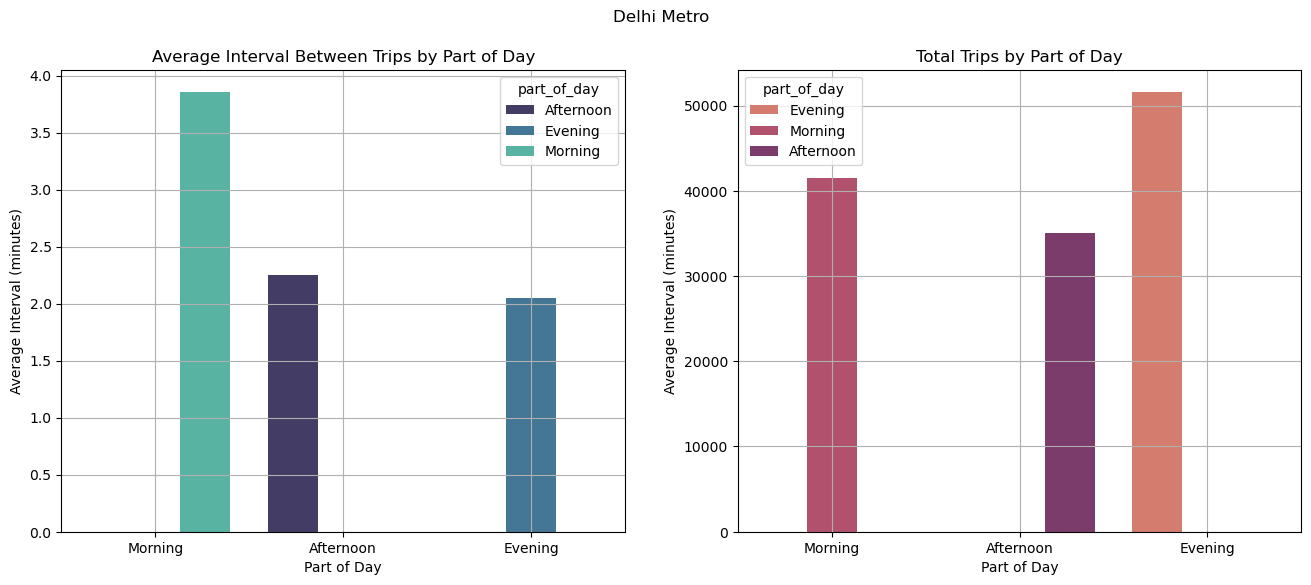

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='mako', hue = 'part_of_day', ax = ax[0])
ax[0].set_title('Average Interval Between Trips by Part of Day')
ax[0].set_xlabel('Part of Day')
ax[0].set_ylabel('Average Interval (minutes)')
ax[0].grid(True)

sns.barplot(x='part_of_day', y='interval_minutes', data=counts, order=['Morning', 'Afternoon', 'Evening'], palette=sns.color_palette("flare", n_colors = counts['part_of_day'].count()), hue = 'part_of_day', ax = ax[1])

ax[1].set_title('Total Trips by Part of Day')
ax[1].set_xlabel('Part of Day')
ax[1].set_ylabel('Average Interval (minutes)')
ax[1].grid(True)

plt.suptitle('Delhi Metro')
plt.show()

In the morning, the time intervals between metro services are the longest due to increased traffic and the sequential commencement of multiple metro lines. Conversely, the afternoon sees reduced frequency and fewer trips, attributed to lower commuter demand. Contrasting with the morning and afternoon, the evening period experiences the shortest time intervals and the highest number of trips, as a result of heightened traffic from individuals returning home after work.

###  trips during time intervals

In [22]:
stop_times['arrival_time'] = stop_times['arrival_time'].str.replace(r'^(24|25):', '00:', regex=True)
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S').dt.time

In [23]:
stop_times['time_interval'] = None

# Set conditions in reverse order to prevent overwriting
stop_times.loc[stop_times['arrival_time'] > dt.time(20,0), 'time_interval'] = 'Night'
stop_times.loc[(stop_times['arrival_time'] > dt.time(16,0)) & (stop_times['arrival_time'] <= dt.time(20,0)), 'time_interval'] = 'Evening Peak'
stop_times.loc[(stop_times['arrival_time'] > dt.time(10,0)) & (stop_times['arrival_time'] <= dt.time(16,0)), 'time_interval'] = 'Midday'
stop_times.loc[(stop_times['arrival_time'] > dt.time(6,0)) & (stop_times['arrival_time'] <= dt.time(10,0)), 'time_interval'] = 'Morning Peak'
stop_times.loc[stop_times['arrival_time'] <= dt.time(6,0), 'time_interval'] = 'Early Morning'



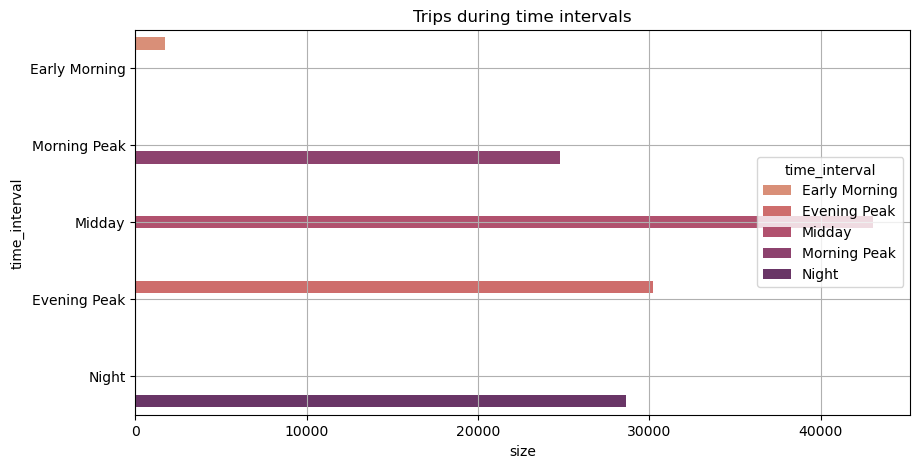

In [24]:
stop_time_grouped = stop_times.groupby('time_interval', as_index = False).size()
plt.figure(figsize = (10,5))
sns.barplot(data=stop_time_grouped, x='size', y='time_interval', order=['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Night'], hue='time_interval', palette=sns.color_palette("flare", n_colors= stop_time_grouped['time_interval'].count()))
plt.title('Trips during time intervals')
plt.grid()
plt.show()

- Early Morning: There is a relatively low number of trips, indicating less demand or fewer scheduled services during these hours.
  
- Morning Peak: There is a significant increase in the number of trips compared to the early morning, likely due to morning commute hours as people travel to work or school.
  
- Midday: The number of trips remains high, perhaps sustaining the morning rush or due to other midday travel needs.

- Evening Peak: This period sees a slight decrease compared to midday but remains one of the busier times, probably reflecting the evening commute.

  
- Late Evening: The number of trips drops again, but remains higher than in the early morning, likely catering to people returning home late or involved in evening activities.

###  Recommendation



- **Optimize Weekday Schedules:** Maintain the consistent service schedule on weekdays to accommodate regular commuter traffic.

- **Adjust Weekend Services:** Consider reducing the number of trips on weekends in response to lower demand, optimizing resource allocation.

- **Enhance Spatial Coverage:** Ensure widespread distribution of metro stops for efficient travel across Delhi, while evaluating denser clusters for potential service enhancements.

- **Morning Service Management:** Increase early morning services to manage increased traffic and stagger the commencement of metro lines for smoother operations.

- **Afternoon Frequency Adjustment:** Reduce service frequency in the afternoon to match lower commuter demand, optimizing operational efficiency.

- **Evening Rush Hour Planning:** Implement shorter intervals between services during evening peak hours to accommodate high traffic volumes, ensuring timely and efficient commutes.

By strategically scaling operations and adjusting service frequencies based on time-of-day and day-of-week ridership patterns, Delhi Metro can optimize its network for operational efficiency and enhanced commuter experience.